In [1]:
import folium
import geopy
from geopy.extra.rate_limiter import RateLimiter
import pandas as pd
import numpy as np
from folium.plugins import FastMarkerCluster
from pandas.io.json import json_normalize
import json
from shapely.geometry import shape, Point
import os
import requests
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
npu = os.path.join('Data', 'NPU_DATA.csv')
crime = os.path.join('Data', 'COBRA-2019.csv')

atl_df = pd.read_csv(npu)
crime_df = pd.read_csv(crime)

In [3]:
atl_df.head()

,Unnamed: 0,NPU,"Count, Total population, 2015","Median, Median age (years), 2015","Median, Median value of owner-occupied unit (dollars), 2015","Median, Median gross rent (dollars), 2015","Median, Median household Income, 2015","Percent, Public transportation (excluding taxicab) to work, 2015","Percent, Walked to work, 2015","Percent, Other means to work, 2015",Crime Count,Neighborhood,Location,Coordinate
0,0,NPU V,5328,34.7,72308.0,894.0,20732.0,37.0,2.3,0.6,187,Adair Park,"Adair Park, Atlanta, GA 30310, USA","(33.7302639, -84.4107008)"
1,1,NPU V,3524,33.6,155834.0,774.0,22852.0,11.5,4.5,3.3,187,Capitol Gateway,"89 Woodward Ave SE, Atlanta, GA 30312, USA","(33.7453143, -84.38412249999999)"
2,2,NPU V,3645,27.5,85625.0,668.0,17484.0,28.6,0.0,0.0,187,Mechanicsville,"Mechanicsville, Atlanta, GA, USA","(33.7419681, -84.3957413)"
3,3,NPU V,3044,29.6,120366.0,847.0,20292.0,12.9,1.6,2.4,187,Peoplestown,"Peoplestown, Atlanta, GA 30315, USA","(33.7278848, -84.3852043)"
4,4,NPU R,7148,34.6,115395.0,867.0,33988.0,17.0,1.2,1.0,146,Adams Park,"Adams Park, Atlanta, GA 30311, USA","(33.7144587, -84.4618943)"


In [4]:
atl_df = atl_df.drop('Unnamed: 0', 1)
atl_df.dtypes

NPU                                                                  object
Count, Total population, 2015                                         int64
Median, Median age (years), 2015                                    float64
Median, Median value of owner-occupied unit (dollars), 2015         float64
Median, Median gross rent (dollars), 2015                           float64
Median, Median household Income, 2015                               float64
Percent, Public transportation (excluding taxicab) to work, 2015    float64
Percent, Walked to work, 2015                                       float64
Percent, Other means to work, 2015                                  float64
Crime Count                                                           int64
Neighborhood                                                         object
Location                                                             object
Coordinate                                                           object
dtype: objec

In [5]:
crime_df.head()

,Report Number,Report Date,Occur Date,Occur Time,Possible Date,Possible Time,Beat,Apartment Office Prefix,Apartment Number,Location,Shift Occurrence,Location Type,UCR Literal,UCR #,IBR Code,Neighborhood,NPU,Latitude,Longitude
0,190010138,2019-01-01,2019-01-01,0020,2019-01-01,25,511.0,NaN,NaN,50 UPPER ALABAMA ST SW,Morning Watch,13,LARCENY-NON VEHICLE,620,2302,Downtown,M,33.75194,-84.38964
1,190010299,2019-01-01,2019-01-01,0120,2019-01-01,130,511.0,NaN,NaN,20 BROAD ST,Morning Watch,NaN,LARCENY-NON VEHICLE,620,2302,Downtown,M,33.75312,-84.39208
2,190011858,2019-01-01,2019-01-01,1740,2019-01-01,1750,411.0,NaN,A15,3000 CONTINENTAL COLONY PKWY SW,Evening Watch,26,LARCENY-NON VEHICLE,620,2302,Greenbriar,R,33.68077,-84.49370
3,190010845,2019-01-01,2019-01-01,0415,2019-01-01,420,607.0,NaN,NaN,1362 BOULEVARD SE,Morning Watch,23,LARCENY-NON VEHICLE,630,2303,Benteen Park,W,33.71744,-84.36818
4,190011541,2019-01-01,2019-01-01,1400,2019-01-01,1430,210.0,NaN,NaN,3393 PEACHTREE RD NE @LENOX MALL,Evening Watch,8,LARCENY-NON VEHICLE,630,2303,Lenox,B,33.84676,-84.36212


In [6]:
crime_df.dtypes

Report Number                int64
Report Date                 object
Occur Date                  object
Occur Time                  object
Possible Date               object
Possible Time                int64
Beat                       float64
Apartment Office Prefix     object
Apartment Number            object
Location                    object
Shift Occurrence            object
Location Type               object
UCR Literal                 object
UCR #                        int64
IBR Code                    object
Neighborhood                object
NPU                         object
Latitude                   float64
Longitude                  float64
dtype: object

I am stealing a small little helper class I wrote for another project. It's purpose is to, using a geojson, determine in which region a given point lies.

In [7]:
class Locator:
    def __init__(self, geojson):
        with open(geojson) as f:
            self.js = json.load(f)
    def feature_name(self, pt):
        point = Point(pt)
        for feature in self.js['features']:
            poly = shape(feature['geometry'])
            if poly.contains(point):
                return feature['properties']['PAGENAME_1']

In [8]:
jsonpath = os.path.join('Data', 'NPU.json')
locator = Locator(jsonpath)
crime_df['Coordinate'] = crime_df[['Latitude', 'Longitude']].apply(lambda x: (x[1], x[0]), axis=1)
crime_df['NPU'] = crime_df['Coordinate'].apply(locator.feature_name)
crime_df['NPU'] = crime_df['NPU'].apply(lambda x: x[:3] + ' ' + x[-1] if x else x)
crime_df.head()

,Report Number,Report Date,Occur Date,Occur Time,Possible Date,Possible Time,Beat,Apartment Office Prefix,Apartment Number,Location,Shift Occurrence,Location Type,UCR Literal,UCR #,IBR Code,Neighborhood,NPU,Latitude,Longitude,Coordinate
0,190010138,2019-01-01,2019-01-01,0020,2019-01-01,25,511.0,NaN,NaN,50 UPPER ALABAMA ST SW,Morning Watch,13,LARCENY-NON VEHICLE,620,2302,Downtown,NPU M,33.75194,-84.38964,"(-84.38964, 33.75194)"
1,190010299,2019-01-01,2019-01-01,0120,2019-01-01,130,511.0,NaN,NaN,20 BROAD ST,Morning Watch,NaN,LARCENY-NON VEHICLE,620,2302,Downtown,NPU M,33.75312,-84.39208,"(-84.39208, 33.75312)"
2,190011858,2019-01-01,2019-01-01,1740,2019-01-01,1750,411.0,NaN,A15,3000 CONTINENTAL COLONY PKWY SW,Evening Watch,26,LARCENY-NON VEHICLE,620,2302,Greenbriar,NPU R,33.68077,-84.49370,"(-84.4937, 33.68077)"
3,190010845,2019-01-01,2019-01-01,0415,2019-01-01,420,607.0,NaN,NaN,1362 BOULEVARD SE,Morning Watch,23,LARCENY-NON VEHICLE,630,2303,Benteen Park,NPU W,33.71744,-84.36818,"(-84.36817999999998, 33.71744)"
4,190011541,2019-01-01,2019-01-01,1400,2019-01-01,1430,210.0,NaN,NaN,3393 PEACHTREE RD NE @LENOX MALL,Evening Watch,8,LARCENY-NON VEHICLE,630,2303,Lenox,NPU B,33.84676,-84.36212,"(-84.36212, 33.84676)"


In [9]:
violent_crimes = ['AGG ASSAULT', 'HOMICIDE', 'LARCENY-FROM VEHICLE', 'ROBBERY-PEDESTRIAN', 'LARCENY-NON VEHICLE']
num_violent_crimes = crime_df[crime_df['UCR Literal'].isin(violent_crimes)].groupby('NPU').size()

In [10]:
import IPython
crime_map = os.path.join('Figures', 'atl_crime_map.html')
IPython.display.IFrame(crime_map, 1500, 1000)

In [11]:
atl_df.shape

(102, 13)

In [12]:
# atl_df = atl_df.merge(num_violent_crimes.to_frame(), on='NPU', suffixes=('', '_y'))

In [13]:
atl_df.rename(columns={0: 'Crime Count'}, inplace=True)
atl_df.head()

,NPU,"Count, Total population, 2015","Median, Median age (years), 2015","Median, Median value of owner-occupied unit (dollars), 2015","Median, Median gross rent (dollars), 2015","Median, Median household Income, 2015","Percent, Public transportation (excluding taxicab) to work, 2015","Percent, Walked to work, 2015","Percent, Other means to work, 2015",Crime Count,Neighborhood,Location,Coordinate
0,NPU V,5328,34.7,72308.0,894.0,20732.0,37.0,2.3,0.6,187,Adair Park,"Adair Park, Atlanta, GA 30310, USA","(33.7302639, -84.4107008)"
1,NPU V,3524,33.6,155834.0,774.0,22852.0,11.5,4.5,3.3,187,Capitol Gateway,"89 Woodward Ave SE, Atlanta, GA 30312, USA","(33.7453143, -84.38412249999999)"
2,NPU V,3645,27.5,85625.0,668.0,17484.0,28.6,0.0,0.0,187,Mechanicsville,"Mechanicsville, Atlanta, GA, USA","(33.7419681, -84.3957413)"
3,NPU V,3044,29.6,120366.0,847.0,20292.0,12.9,1.6,2.4,187,Peoplestown,"Peoplestown, Atlanta, GA 30315, USA","(33.7278848, -84.3852043)"
4,NPU R,7148,34.6,115395.0,867.0,33988.0,17.0,1.2,1.0,146,Adams Park,"Adams Park, Atlanta, GA 30311, USA","(33.7144587, -84.4618943)"


In [14]:
# atl_df['Neighborhood'] = atl_df['Neighborhoods'].apply(lambda x: x.split(',')[0] if x else x)
# atl_df.drop('Neighborhoods', axis=1, inplace=True)
# atl_df.head()

In [15]:
# google_key = ''
# geocoder = geopy.geocoders.GoogleV3(api_key=google_key)
# geocode = RateLimiter(geocoder.geocode, min_delay_seconds=.1)

In [16]:
# atl_df['Location'] = atl_df['Neighborhood'].apply(lambda x: x + ' Atlanta, GA')
# atl_df['Location'] = atl_df['Location'].apply(geocode)

In [17]:
# atl_df['Coordinate'] = atl_df['Location'].apply(lambda loc: tuple(loc.point[0:2]) if loc else None)

In [18]:
# atl_df.to_csv(r'Data/NPU_DATA.csv')

In [19]:
atl_df.head()

,NPU,"Count, Total population, 2015","Median, Median age (years), 2015","Median, Median value of owner-occupied unit (dollars), 2015","Median, Median gross rent (dollars), 2015","Median, Median household Income, 2015","Percent, Public transportation (excluding taxicab) to work, 2015","Percent, Walked to work, 2015","Percent, Other means to work, 2015",Crime Count,Neighborhood,Location,Coordinate
0,NPU V,5328,34.7,72308.0,894.0,20732.0,37.0,2.3,0.6,187,Adair Park,"Adair Park, Atlanta, GA 30310, USA","(33.7302639, -84.4107008)"
1,NPU V,3524,33.6,155834.0,774.0,22852.0,11.5,4.5,3.3,187,Capitol Gateway,"89 Woodward Ave SE, Atlanta, GA 30312, USA","(33.7453143, -84.38412249999999)"
2,NPU V,3645,27.5,85625.0,668.0,17484.0,28.6,0.0,0.0,187,Mechanicsville,"Mechanicsville, Atlanta, GA, USA","(33.7419681, -84.3957413)"
3,NPU V,3044,29.6,120366.0,847.0,20292.0,12.9,1.6,2.4,187,Peoplestown,"Peoplestown, Atlanta, GA 30315, USA","(33.7278848, -84.3852043)"
4,NPU R,7148,34.6,115395.0,867.0,33988.0,17.0,1.2,1.0,146,Adams Park,"Adams Park, Atlanta, GA 30311, USA","(33.7144587, -84.4618943)"


We will now use Foursquare to determine the primary attractions in these neighborhoods.

In [20]:
# CLIENT_ID = ''
# CLIENT_SECRET = ''
# VERSION = 20190417
# LIMIT = 100

In [21]:
# def getNearbyVenues(names, coordinates, radius=1000):
    
#     venues_list = []
#     for name, coord in zip(names, coordinates):
#         url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
#             CLIENT_ID, 
#             CLIENT_SECRET, 
#             VERSION, 
#             coord[0], 
#             coord[1], 
#             radius, 
#             LIMIT)
#         results = requests.get(url).json()['response']['groups'][0]['items']
        
#         venues_list.append([(
#             name, 
#             coord[0],
#             coord[1],
#             v['venue']['name'], 
#             v['venue']['location']['lat'], 
#             v['venue']['location']['lng'],  
#             v['venue']['categories'][0]['name']) for v in results])
        
#         nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
#         nearby_venues.columns = ['Neighborhood', 
#                   'Neighborhood Latitude', 
#                   'Neighborhood Longitude', 
#                   'Venue', 
#                   'Venue Latitude', 
#                   'Venue Longitude', 
#                   'Venue Category']
#     return nearby_venues

In [22]:
# venues = getNearbyVenues(atl_df['Neighborhood'], atl_df['Coordinate'])

In [23]:
# venues.to_csv(os.path.join('Data', 'venues.csv'))

In [24]:
venues = pd.read_csv(os.path.join('Data', 'venues.csv'))

In [25]:
venues = venues.set_index(['Unnamed: 0'])
venues = venues.reset_index(drop=True)
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adair Park,33.730264,-84.410701,Adair Park One,33.730525,-84.412837,Park
1,Adair Park,33.730264,-84.410701,Monday Night Garage,33.729407,-84.418303,Brewery
2,Adair Park,33.730264,-84.410701,Boxcar Atl,33.729955,-84.417383,Gastropub
3,Adair Park,33.730264,-84.410701,Atlanta BeltLine Corridor under Lee/Murphy,33.727205,-84.417238,Trail
4,Adair Park,33.730264,-84.410701,Krispy Kreme Doughnuts,33.737630,-84.415950,Donut Shop


In [26]:
venues.shape

(3658, 7)

In [27]:
len(venues['Venue Category'].unique())

321

In [28]:
oh_df = pd.get_dummies(venues[['Venue Category']], prefix='', prefix_sep='')
oh_df['Name'] = venues['Neighborhood']

cols = [oh_df.columns[-1]] + list(oh_df.columns[:-1])
oh_df = oh_df[cols]

oh_df.head()

,Name,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,...,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Adair Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adair Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adair Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adair Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adair Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
oh_grp = oh_df.groupby('Name').mean().reset_index()
oh_grp.head()

,Name,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,...,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Adair Park,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0
1,Adams Park,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.055556,...,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0
2,Adamsville,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Airport,0.0,0.0,0.0,0.01,0.01,0.01,0.07,0.05,0.050000,...,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.0
4,Almond Park,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [30]:
oh_grp.shape

(102, 322)

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = oh_grp['Name']

for ind in np.arange(oh_grp.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(oh_grp.iloc[ind, :], num_top_venues)


In [33]:
neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adair Park,Liquor Store,Trail,Southern / Soul Food Restaurant,Art Gallery,Sandwich Place,Gastropub,Light Rail Station,Market,Clothing Store,Beer Store
1,Adams Park,Chinese Restaurant,Fast Food Restaurant,Sandwich Place,Discount Store,Golf Course,BBQ Joint,Caribbean Restaurant,Dry Cleaner,Park,Gas Station
2,Adamsville,Fried Chicken Joint,Discount Store,Gas Station,Liquor Store,Fast Food Restaurant,Seafood Restaurant,Gym / Fitness Center,Laundromat,Roller Rink,Food
3,Airport,Airport Lounge,Sandwich Place,American Restaurant,Airport Service,Electronics Store,Coffee Shop,Fast Food Restaurant,Cosmetics Shop,Fried Chicken Joint,Burger Joint
4,Almond Park,Home Service,Steakhouse,Discount Store,Nightclub,Gas Station,Fast Food Restaurant,Chinese Restaurant,Seafood Restaurant,Laundromat,Asian Restaurant
5,Amal Heights,Trail,Caribbean Restaurant,Music Venue,Hotel,Park,Bar,Southern / Soul Food Restaurant,Chinese Restaurant,Non-Profit,Farm
6,Ansley Park,American Restaurant,Coffee Shop,Botanical Garden,Shopping Mall,Gay Bar,Sandwich Place,Music Venue,Trail,Gym / Fitness Center,Golf Course
7,Arden/Habersham,Ski Trail,Plaza,Speakeasy,Baseball Stadium,Spa,Dessert Shop,Music Venue,Park,Men's Store,Gym
8,Ardmore,Mexican Restaurant,Park,Vegetarian / Vegan Restaurant,Pharmacy,Fast Food Restaurant,Trail,New American Restaurant,Gym / Fitness Center,Lounge,Bar
9,Arlington Estates,Discount Store,Seafood Restaurant,Park,Caribbean Restaurant,Gym / Fitness Center,Liquor Store,Flower Shop,Exhibit,Ethiopian Restaurant,Food Stand


In [34]:
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

In [35]:
klist = [i for i in range(2, 15)]
grp_clster = oh_grp.drop('Name', 1)
metric = list(klist)
spec_metric = list(klist)
for k in klist:
    kmeans = KMeans(n_clusters=k, random_state=3).fit(grp_clster)
    metric[k-2] = metrics.silhouette_score(grp_clster, kmeans.labels_)
    
    spec = SpectralClustering(n_clusters=k).fit(grp_clster)
    spec_metric[k-2] = metrics.silhouette_score(grp_clster, spec.labels_)
    
dbs = DBSCAN(min_samples=7).fit(grp_clster)
dbs_metric = [len(dbs.labels_), metrics.silhouette_score(grp_clster, dbs.labels_)]

[102, 0.4760675970766008]


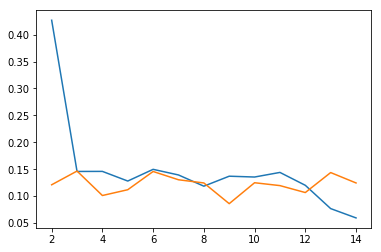

In [36]:
plt.plot(klist, metric)
plt.plot(klist, spec_metric)
print(dbs_metric)
plt.show()

Honestly these categories are not good except to consider only 2 clusters. The above graph shows the silhouette score for kmeans, dbscan, and spectral clustering.  
This will require a change in approach. Let's take a look at our categories and use it to train a model.

In [37]:
from sklearn import preprocessing

In [38]:
atl_df.head()

,NPU,"Count, Total population, 2015","Median, Median age (years), 2015","Median, Median value of owner-occupied unit (dollars), 2015","Median, Median gross rent (dollars), 2015","Median, Median household Income, 2015","Percent, Public transportation (excluding taxicab) to work, 2015","Percent, Walked to work, 2015","Percent, Other means to work, 2015",Crime Count,Neighborhood,Location,Coordinate
0,NPU V,5328,34.7,72308.0,894.0,20732.0,37.0,2.3,0.6,187,Adair Park,"Adair Park, Atlanta, GA 30310, USA","(33.7302639, -84.4107008)"
1,NPU V,3524,33.6,155834.0,774.0,22852.0,11.5,4.5,3.3,187,Capitol Gateway,"89 Woodward Ave SE, Atlanta, GA 30312, USA","(33.7453143, -84.38412249999999)"
2,NPU V,3645,27.5,85625.0,668.0,17484.0,28.6,0.0,0.0,187,Mechanicsville,"Mechanicsville, Atlanta, GA, USA","(33.7419681, -84.3957413)"
3,NPU V,3044,29.6,120366.0,847.0,20292.0,12.9,1.6,2.4,187,Peoplestown,"Peoplestown, Atlanta, GA 30315, USA","(33.7278848, -84.3852043)"
4,NPU R,7148,34.6,115395.0,867.0,33988.0,17.0,1.2,1.0,146,Adams Park,"Adams Park, Atlanta, GA 30311, USA","(33.7144587, -84.4618943)"


In [39]:
columnmap = {'Count, Total population, 2015': 'Population', 
             'Median, Median age (years), 2015': 'Median Age', 
             'Median, Median value of owner-occupied unit (dollars), 2015': 'Median House Value', 
             'Median, Median gross rent (dollars), 2015': 'Median Rent', 
             'Median, Median household Income, 2015': 'Median Household Income', 
             'Percent, Public transportation (excluding taxicab) to work, 2015': 'Public Transit', 
             'Percent, Walked to work, 2015': 'Walk', 
             'Percent, Other means to work, 2015': 'Other transit'}
atl_df = atl_df.rename(columns=columnmap)
atl_df.head()

,NPU,Population,Median Age,Median House Value,Median Rent,Median Household Income,Public Transit,Walk,Other transit,Crime Count,Neighborhood,Location,Coordinate
0,NPU V,5328,34.7,72308.0,894.0,20732.0,37.0,2.3,0.6,187,Adair Park,"Adair Park, Atlanta, GA 30310, USA","(33.7302639, -84.4107008)"
1,NPU V,3524,33.6,155834.0,774.0,22852.0,11.5,4.5,3.3,187,Capitol Gateway,"89 Woodward Ave SE, Atlanta, GA 30312, USA","(33.7453143, -84.38412249999999)"
2,NPU V,3645,27.5,85625.0,668.0,17484.0,28.6,0.0,0.0,187,Mechanicsville,"Mechanicsville, Atlanta, GA, USA","(33.7419681, -84.3957413)"
3,NPU V,3044,29.6,120366.0,847.0,20292.0,12.9,1.6,2.4,187,Peoplestown,"Peoplestown, Atlanta, GA 30315, USA","(33.7278848, -84.3852043)"
4,NPU R,7148,34.6,115395.0,867.0,33988.0,17.0,1.2,1.0,146,Adams Park,"Adams Park, Atlanta, GA 30311, USA","(33.7144587, -84.4618943)"


In [40]:
data = atl_df.sort_values('Neighborhood')
data = data.reset_index()
data = data.drop(['Location', 'Coordinate', 'Neighborhood', 'NPU', 'index'], 1)
data.head()

,Population,Median Age,Median House Value,Median Rent,Median Household Income,Public Transit,Walk,Other transit,Crime Count
0,5328,34.7,72308.0,894.0,20732.0,37.0,2.3,0.6,187
1,7148,34.6,115395.0,867.0,33988.0,17.0,1.2,1.0,146
2,2312,29.9,64550.0,747.0,19798.0,22.7,3.6,0.1,81
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161
4,2795,24.6,52729.0,639.0,19492.0,22.2,1.6,0.0,71


In [41]:
data['Public Transit'] = data['Public Transit'].apply(lambda x: x / 100.0)
data['Walk'] = data['Walk'].apply(lambda x: x / 100.0)
data['Other transit'] = data['Other transit'].apply(lambda x: x / 100.0)
data.head()

,Population,Median Age,Median House Value,Median Rent,Median Household Income,Public Transit,Walk,Other transit,Crime Count
0,5328,34.7,72308.0,894.0,20732.0,0.370,0.023,0.006,187
1,7148,34.6,115395.0,867.0,33988.0,0.170,0.012,0.010,146
2,2312,29.9,64550.0,747.0,19798.0,0.227,0.036,0.001,81
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161
4,2795,24.6,52729.0,639.0,19492.0,0.222,0.016,0.000,71


In [42]:
oh_grp.head()

,Name,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,...,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Adair Park,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0
1,Adams Park,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.055556,...,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0
2,Adamsville,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Airport,0.0,0.0,0.0,0.01,0.01,0.01,0.07,0.05,0.050000,...,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.0
4,Almond Park,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [43]:
oh_grp = oh_grp.join(data, how='outer')

In [44]:
oh_grp.head()

,Name,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,...,Zoo Exhibit,Population,Median Age,Median House Value,Median Rent,Median Household Income,Public Transit,Walk,Other transit,Crime Count
0,Adair Park,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.0,5328,34.7,72308.0,894.0,20732.0,0.370,0.023,0.006,187
1,Adams Park,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.055556,...,0.0,7148,34.6,115395.0,867.0,33988.0,0.170,0.012,0.010,146
2,Adamsville,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.0,2312,29.9,64550.0,747.0,19798.0,0.227,0.036,0.001,81
3,Airport,0.0,0.0,0.0,0.01,0.01,0.01,0.07,0.05,0.050000,...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161
4,Almond Park,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.0,2795,24.6,52729.0,639.0,19492.0,0.222,0.016,0.000,71


In [45]:
# list(oh_grp)

In [46]:
valid_venues = 'Gastropub,Burger Joint,Candy Store,Dive Bar,Fish & Chips Shop,Fried Chicken Joint'.split(',')
valid_venues

['Gastropub',
 'Burger Joint',
 'Candy Store',
 'Dive Bar',
 'Fish & Chips Shop',
 'Fried Chicken Joint']

In [47]:
valid_venues.append('Name')
x = oh_grp.drop(valid_venues, 1)
oh_grp = oh_grp.dropna(how='any', axis=0)
x = x.dropna(how='any', axis=0)
X = preprocessing.StandardScaler().fit(x).transform(x)

/home/silas/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/silas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [48]:
X

array([[-0.17650172, -0.15708281, -0.10050378, ..., -0.11657404,
        -0.62033519, -0.19812844],
       [-0.17650172, -0.15708281, -0.10050378, ..., -0.31355015,
        -0.32387871, -0.42086675],
       [-0.17650172, -0.15708281, -0.10050378, ...,  0.1162159 ,
        -0.99090579, -0.77398847],
       ...,
       [-0.17650172, -0.15708281, -0.10050378, ...,  0.31319201,
         0.34314838, -0.35567505],
       [-0.17650172, -0.15708281, -0.10050378, ..., -0.20610864,
         0.71371898, -0.25245486],
       [-0.17650172, -0.15708281, -0.10050378, ...,  0.1162159 ,
         0.86194722, -0.25245486]])

In [49]:
# valid_venues = 'Gastropub,Burger Joint,Candy Store,Dive Bar,Fish & Chips Shop,Fried Chicken Joint'.split(',')
# valid_venues

In [50]:
venue_freq = oh_grp[valid_venues]
def num_items(x, thresh):
    s = 0
    for xi in x:
        if xi > thresh:
            s += 1
    return s
venue_freq['Ideal'] = venue_freq.sum(axis=1)

/home/silas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [51]:
np.average(venue_freq['Ideal'].unique())

0.045330811307695104

In [52]:
y = np.array(venue_freq['Ideal'])
y

array([0.04166667, 0.        , 0.16666667, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04761905, 0.03      , 0.        , 0.04347826, 0.02      ,
       0.        , 0.        , 0.1       , 0.        , 0.        ,
       0.06666667, 0.        , 0.        , 0.        , 0.06818182,
       0.        , 0.        , 0.        , 0.02631579, 0.01587302,
       0.125     , 0.01      , 0.03      , 0.        , 0.08333333,
       0.08      , 0.        , 0.02150538, 0.02380952, 0.        ,
       0.        , 0.07692308, 0.        , 0.03508772, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03448276,
       0.        , 0.        , 0.01960784, 0.1       , 0.03921569,
       0.04      , 0.        , 0.        , 0.        , 0.03636364,
       0.01204819, 0.03508772, 0.03225806, 0.        , 0.02777778,
       0.07      , 0.        , 0.02      , 0.        , 0.        ,
       0.03225806, 0.08333333, 0.        , 0.        , 0.     

In [53]:
for i in range(0, len(y)):
    if y[i] > .045:
        y[i] = 1.0
    else:
        y[i] = 0

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (80, 324) (80,)
Test set: (20, 324) (20,)


We will now try to model the existence of gastropubs based on the other data. We will focus on KNN, Logistic regression, and SVM.

In [56]:
def AccPlot(mean_acc):
    plt.plot(range(1,len(mean_acc) + 1),mean_acc,'g')
#     plt.fill_between(range(1,len(mean_acc) + 1),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
    plt.legend(('Accuracy ', '+/- 3xstd'))
    plt.ylabel('Accuracy ')
    plt.xlabel('K')
    plt.tight_layout()
    plt.show()

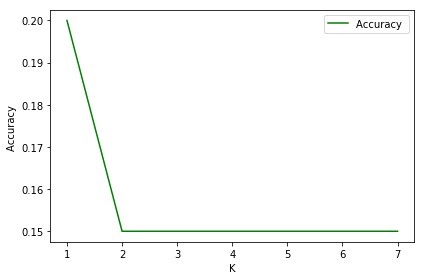

In [57]:
regularization = [.0001, .001, .1, 1, 10, 50, 100]
std = []
mean = []
for i in regularization:
    LR = LogisticRegression(C=i, solver='liblinear').fit(X_train, y_train)
    y_hat = LR.predict(X_test)
    mean.append(metrics.accuracy_score(y_test, y_hat))
#     std.append(np.std(y==y_test)/np.sqrt(y.shape[0]))
AccPlot(np.array(mean))

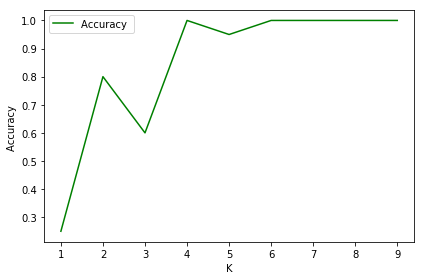

In [58]:
from sklearn.neighbors import KNeighborsClassifier
mean = []
std = []
for i in range(1, 10):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train, y_train)
    y_hat = neigh.predict(X_test)
    mean.append(metrics.accuracy_score(y_test, y_hat))
#     std.append(np.std(y==y_test)/np.sqrt(y.shape[0]))

AccPlot(np.array(mean))

KNN peaks at just under explaining 85% of the data.

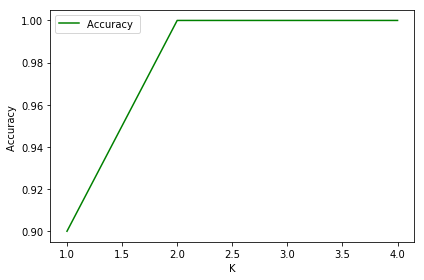

In [59]:
from sklearn import svm
k_functions = ['linear', 'poly', 'rbf', 'sigmoid']
mean = []
std = []
for i in k_functions:
    clf = svm.SVC(kernel=i, gamma='auto')
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    mean.append(metrics.accuracy_score(y_test, y_hat))
#     std.append(np.std(y==y_test)/np.sqrt(y.shape[0]))
AccPlot(np.array(mean))

80% of the data is explained by this model

In [60]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [61]:
import pickle

In [62]:
fname = os.path.join('Model', 'model.sav')
pickle.dump(knn, open(fname, 'wb'))

In [63]:
Y = knn.predict(X)

In [64]:
Y

array([1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.])

In [65]:
indices = []
for yi in range(len(Y)):
    if Y[yi] > .5:
        indices.append(yi)
indices

[0,
 2,
 5,
 8,
 13,
 14,
 20,
 24,
 25,
 30,
 31,
 34,
 35,
 41,
 45,
 48,
 53,
 56,
 61,
 65,
 67,
 71,
 79,
 95,
 98,
 99]

In [79]:
filtered_locations = oh_grp.iloc[indices]

In [82]:
filtered_locations = filtered_locations.sort_values('Crime Count')
cols = ['Name', 'Crime Count'] + list(columnmap.values())
filtered_locations = filtered_locations[cols]
filtered_locations

,Name,Crime Count,Population,Median Age,Median House Value,Median Rent,Median Household Income,Public Transit,Walk,Other transit
73,Knight Park/Howell Station,65,2788,35.8,217361.0,1194.0,74483.0,0.000,0.007,0.034
42,Cascade Avenue/Road,80,2490,40.2,80416.0,1129.0,36688.0,0.202,0.017,0.006
35,Bush Mountain,80,4021,35.0,67118.0,876.0,21669.0,0.292,0.015,0.006
2,Adamsville,81,2312,29.9,64550.0,747.0,19798.0,0.227,0.036,0.001
58,Fairburn Mays,81,5135,31.0,64989.0,799.0,28803.0,0.227,0.020,0.002
46,Channing Valley,107,4221,32.0,606131.0,1222.0,106681.0,0.014,0.000,0.003
50,Collier Hills,107,2806,34.3,309739.0,1128.0,62494.0,0.045,0.010,0.005
9,Arlington Estates,123,4265,37.1,108239.0,1024.0,40642.0,0.103,0.013,0.012
21,Ben Hill Acres,123,3313,32.5,102303.0,935.0,47645.0,0.141,0.009,0.006
26,Blair Villa/Poole Creek,136,7190,29.8,67647.0,815.0,22510.0,0.197,0.000,0.018


In [ ]:
# filtered_locations.to_csv(os.path.join('Data', 'Neighborhoods'))

In [85]:
filtered_locations.describe()

,Crime Count,Population,Median Age,Median House Value,Median Rent,Median Household Income,Public Transit,Walk,Other transit
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,225.730769,4867.307692,32.530769,192865.346154,1018.576923,49760.923077,0.129885,0.043038,0.020654
std,182.914309,3031.126626,5.139632,135777.261459,210.689567,28557.217545,0.104533,0.071158,0.017929
min,65.000000,2312.000000,20.500000,64550.000000,721.000000,10480.000000,0.000000,0.000000,0.000000
25%,111.000000,3132.250000,30.175000,82680.750000,822.250000,23864.500000,0.045000,0.007500,0.006000
50%,155.500000,4213.000000,32.800000,183093.500000,992.000000,45581.500000,0.104000,0.017500,0.019000
75%,221.000000,5279.750000,35.700000,256207.250000,1188.750000,67895.500000,0.221000,0.036000,0.033750
max,587.000000,17881.000000,42.300000,606131.000000,1487.000000,116146.000000,0.370000,0.297000,0.072000


In [91]:
result = filtered_locations.sort_values(by=['Median Household Income', 'Median Age', 'Crime Count'], ascending=[False, True, True]).iloc[:5]

Add binning in future.

In [92]:
result

,Name,Crime Count,Population,Median Age,Median House Value,Median Rent,Median Household Income,Public Transit,Walk,Other transit
6,Ansley Park,587,3379,42.3,482237.0,1305.0,116146.0,0.051,0.088,0.023
46,Channing Valley,107,4221,32.0,606131.0,1222.0,106681.0,0.014,0.000,0.003
32,Buckhead Forest,560,2907,32.1,309328.0,1487.0,92923.0,0.004,0.027,0.002
63,Grant Park,169,7258,35.4,263870.0,1239.0,84271.0,0.045,0.031,0.038
73,Knight Park/Howell Station,65,2788,35.8,217361.0,1194.0,74483.0,0.000,0.007,0.034


In [90]:
result.to_csv(os.path.join('Data', 'Result.csv'))